# Detect Pneumonia Using X-Ray Images

we'll take on the role of a Deep Learning Engineer for an R&D company that focuses on developing cutting edge technologies to assist hospitals in diagnosing patients, particularly children. Thanks to researchers from the University of California, San Diego, the company has access to a dataset containing 5856 chest X-ray images from children, split between a training dataset and a test dataset. Each image has a label that specifies if the X-ray corresponds to a patient with pneumonia or one without it.

We're tasked with building a deep learning model trained on these images that can accurately classify whether an X-ray indicates signs of pneumonia.

In this project we will build two deep learning models and train them on a dataset containing images of chest X-rays. The aim of this project is to train classifiers on the dataset that can accurately predict whether an X-ray indicates any signs of pneumonia or not.

The models could then be used for developing tools that could aid hospitals in accurately identifying whether a patient has a particular disease or not.

## Importing Libraries

In [1]:
import os
import gdown
import zipfile
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input, applications, initializers
import matplotlib.pyplot as plt

## Downloading the Dataset

Varying our approach for the sake of exposure, we'll have our data source stored in our Google cloud. The `gdown` library will help facilitate getting this dataset downloaded to our local machine.  

`gdown` documentation: 
- [Pypi](https://pypi.org/project/gdown/)
- [Github](https://github.com/wkentaro/gdown)

In [ ]:
os.makedirs("artifacts/data_ingestion", exist_ok=True) # create directory
prefix = "https://drive.google.com/uc?/export=download&id="
dataset_url = "https://drive.google.com/file/d/1WI9Axo6yRc2ayIemo-hLWpZuKlBb2ydH/view?usp=sharing"
file_id = dataset_url.split("/")[-2] # splitting unique key
zip_download_dir = "artifacts/data_ingestion/data.zip" # location zip file will be downloaded to
gdown.download(prefix + file_id, zip_download_dir)

## Uncompressing and Extracting the Data

With the zip file downloaded, `zipfile` is utilized to extract the dataset.

In [ ]:
# Unzipping the dataset to target folder
unzip_path = "artifacts/data_ingestion/xrays"
os.makedirs(unzip_path, exist_ok=True)
with zipfile.ZipFile("artifacts/data_ingestion/data.zip", 'r') as zip_ref:
    zip_ref.extractall(unzip_path) # extract and send to desired unzipped dataset folder 

## Splitting the Dataset
The dataset will be split into test, training and validation sets. 

In [2]:
#checking current working directory 
%pwd

'c:\\Users\\cisco\\Python_Projects\\ML+AI\\Pneumonia-Detection\\research'

In [3]:
img_size = 256

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='../artifacts/data_ingestion/xrays/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset='training',
    seed=417
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='../artifacts/data_ingestion/xrays/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="validation",
    seed=417
)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='../artifacts/data_ingestion/xrays/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size)
)

normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 5232 files belonging to 2 classes.


## Data Exploration

As seen in the output above, of the 5,232 X-ray images in our dataset, 4,186 will be for training, 837 for validation and 209 for testing.

In [4]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [83]:
train_set_elem = train_set.take(1)

for images, labels in train_set_elem:
  images = images.numpy()
  labels = labels.numpy()

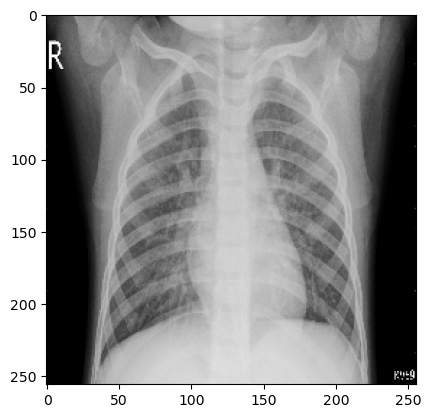

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [84]:
# setting index val
idx = 0

# ensuring image pixels are in range of [0,1]
plt.imshow(images[idx]/255.0)

# showing image
plt.show()

# printing element label and shape of image
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

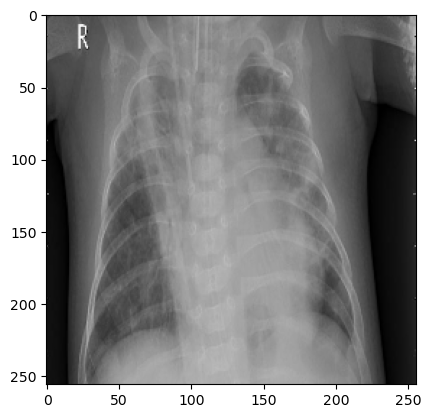

Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)


In [85]:
# taking single element
test_set_elem = test_set.take(1)

# setting index val
idx = 16

# ensuring image pixels are in range of [0,1]
plt.imshow(images[idx]/255.0)

# showing image
plt.show()

# printing element label and shape of image
print(f"Test Set Image Label: {labels[idx]}")
print(f"Test Set Image Shape: {images[idx].shape}")

The images do not all exhibit the same level of clarity (dark space vs. light space).

There are some artifacts present in some of the images (e.g., small overview image of lungs in left hand corner, label in bottom right hand corner, etc.) that could prove problematic if our model learns to associate these irrelevant artifacts with the infection.

Seeing as there might be some issues with these artifacts, it wouldn't be a bad idea to augment these images by cropping or flipping/rotating them.

Despite their greyscale appearance, the images actually have 3 channels.

In this project we'll build multiple models, then evaluate those models on the test set at the end. So it's better to have unique variable names for each of those models.

The first model we'll develop will be simple Convolutional Neural Network (CNN).

## Model \#1: Convolutional Neural Network

We're start off with a simple CNN and compare its results to more complex CNN implementation.

### Simple CNN

In [22]:
simple_cnn_model = models.Sequential()

simple_cnn_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
simple_cnn_model.add(layers.Flatten())
simple_cnn_model.add(layers.Dense(8, activation='relu'))
simple_cnn_model.add(layers.Dense(2))

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
simple_cnn_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

simple_cnn_model.summary()
simple_cnn_model.fit(train_set_normalized, epochs=5, validation_data=validation_set_normalized)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 127, 127, 16)      448       
                                                                 
 flatten_7 (Flatten)         (None, 258064)            0         
                                                                 
 dense_22 (Dense)            (None, 8)                 2064520   
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 2,064,986
Trainable params: 2,064,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
33/33 [==============================] - 8s 178ms/step - loss: 193.5797 - accuracy: 0.6976 - val_loss: 0.5492 - val_accuracy: 0.7629
Epoch 2/5
33/33 [================

In [27]:
print("Simple CNN model parameters:", simple_cnn_model.history.params)

# model history 
simple_cnn_hist = simple_cnn_model.history.history

#printing history keys
simple_cnn_hist_keys = simple_cnn_hist.keys()
print("Simple CNN history keys:")
print(simple_cnn_hist_keys)

#printing accuracy (round 5 digits)
simple_cnn_hist_acc = [round(acc, 5) for acc in simple_cnn_hist['accuracy']]
print("\nSimple CNN training set accuracy:")
print(simple_cnn_hist_acc)

#print validation accuracy (round 5 digits)
simple_cnn_hist_val_acc = [round(acc, 5) for acc in simple_cnn_hist['val_accuracy']]
print("\nSimple CNN validation set accuracy:")
print(simple_cnn_hist_val_acc)

Simple CNN model parameters: {'verbose': 1, 'epochs': 5, 'steps': 33}
Simple CNN history keys:
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Simple CNN training set accuracy:
[0.69756, 0.73698, 0.73698, 0.73698, 0.73698]

Simple CNN validation set accuracy:
[0.76291, 0.76291, 0.76291, 0.76291, 0.76291]


The model's ability to correctly screen the x-ray images were actually higher in the validation (76%) set than in the training set (74%), indicating sings of slight overfitting.

Now that we have a better feel for the baseline of this CNN implementation, let's improve on the model by tweaking a few its aspects and add additional layers until we can get our validation set accuracy above 85% with no more than 10 epochs in our model's training.

### Complex Convolutional Neural Network

In [4]:
# instantiating model
cnn_model = models.Sequential()

# zooming and rotating images
cnn_model.add(layers.RandomZoom(height_factor=0.15, width_factor=0.15))
cnn_model.add(layers.RandomRotation(factor=0.2)) #counter clockwise rotation (+/-)20% * 2pi

cnn_model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
cnn_model.add(layers.MaxPool2D(pool_size=3, strides=2))

cnn_model.add(layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'))
cnn_model.add(layers.MaxPool2D(pool_size=3, strides=2))
cnn_model.add(layers.Flatten())

cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Dense(16, activation='relu'))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Dense(2))

# early stopping callback if val_loss continuously increases after 3 periods
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cnn_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

cnn_model.build((None, img_size, img_size, 3))

cnn_model.summary()

cnn_model.fit(train_set_normalized, epochs=10, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0

In [5]:
print("More complex CNN model parameters:", cnn_model.history.params)

# model history 
cnn_hist = cnn_model.history.history

#printing accuracy (round 5 digits)
cnn_hist_acc = [round(acc, 5) for acc in cnn_hist['accuracy']]
print("\nCNN training set accuracy:")
print(cnn_hist_acc)

#print validation accuracy (round 5 digits)
cnn_hist_val_acc = [round(acc, 5) for acc in cnn_hist['val_accuracy']]
print("\nCNN validation set accuracy:")
print(cnn_hist_val_acc)

More complex CNN model parameters: {'verbose': 1, 'epochs': 10, 'steps': 33}

CNN training set accuracy:
[0.72026, 0.73698, 0.73698, 0.73698, 0.73698]

CNN validation set accuracy:
[0.76291, 0.76291, 0.76291, 0.76291, 0.76291]


The more complex CNN model didn't seem to fair much better than the simpler implementation. Accuracy tops out at around 74% and 76% for the training and validation sets, respectively.

## Implementing Transfer Learning

Transfer learning is a powerful technique in machine learning where a model developed for one task is reused as the starting point for a model on a second task. In the context of medical imaging, such as detecting pneumonia from chest x-rays, transfer learning allows us to leverage pre-trained models that have already learned to recognize patterns in images. This can significantly reduce the time and data required to develop accurate diagnostic tools, making it a valuable approach in the fast-paced field of healthcare analytics.

We plan on utilizing two different transfer learning models: VGG16 and ResNet50v2.

### VGG16 Model

In [11]:
vgg16_model = applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

vgg16_model.trainable = False

input_layer = Input(shape=(img_size, img_size, 3))

# input layers
preprocessed_input_layer = applications.vgg16.preprocess_input(input_layer)

# random zoom and rotation of images
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

features_layer = vgg16_model(preprocessed_input_layer, training=False)

global_pooling = layers.GlobalAveragePooling2D()(features_layer)

# fully connected layers
fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)
fc1 = layers.Dropout(0.5)(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)
fc2 = layers.Dropout(0.5)(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

# output layer
output = layers.Dense(2)(fc3)

vgg16 = Model(inputs=input_layer, outputs=output)

vgg16.summary()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
vgg16.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

vgg16.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         1471

In [12]:
vgg16.history.params

{'verbose': 1, 'epochs': 10, 'steps': 33}

In [34]:
vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         1471

In [13]:
print("VGG16 model parameters: \n", vgg16.history.params)
vgg16_hist = vgg16.history.history

#printing history keys
vgg16_hist_keys = vgg16_hist.keys()
print(vgg16_hist_keys)

#printing accuracy 
vgg16_hist_acc = [round(acc, 5) for acc in vgg16_hist['accuracy']]
print("\nVGG16 training accuracy:")
print(vgg16_hist_acc)

vgg16_hist_val_acc = [round(acc, 5) for acc in vgg16_hist['val_accuracy']]
print("\nVGG16 validation set accuracy:")
print(vgg16_hist_val_acc)

VGG16 model parameters: 
 {'verbose': 1, 'epochs': 10, 'steps': 33}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

VGG16 training accuracy:
[0.65576, 0.76613, 0.88247, 0.91376, 0.92403, 0.92857]

VGG16 validation set accuracy:
[0.76291, 0.89484, 0.91969, 0.93308, 0.89771, 0.90822]


A big jump from the even the more complex CNN model, accuracy in predicting pneumonia from X-rays alone when implementing a modified VGG16 model peaks close to 93% for both training and validation sets! Not only that, it only took 6 epochs to consistently score over the 85% threshold aimed for. 

### RestNet50v2 Model

In [5]:
rn50_v2_model = applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

rn50_v2_model.trainable = False

input_layer = Input(shape=(img_size, img_size, 3))

# input layers
preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)

# random zoom and rotation of images
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

features_layer = rn50_v2_model(preprocessed_input_layer, training=False)

global_pooling = layers.GlobalAveragePooling2D()(features_layer)

# fully connected layers
fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)
fc1 = layers.Dropout(0.5)(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)
fc2 = layers.Dropout(0.5)(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

# output layer
output = layers.Dense(2)(fc3)

rn50_v2 = Model(inputs=input_layer, outputs=output)

rn50_v2.summary()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
rn50_v2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

rn50_v2.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                             

In [54]:
rn50_v2.history.params

{'verbose': 1, 'epochs': 10, 'steps': 33}

In [10]:
rn50_v2_hist = rn50_v2.history.history

#printing history keys
rn50_v2_hist_keys = rn50_v2_hist.keys()
print(rn50_v2_hist_keys)

#printing accuracy 
rn50_v2_hist_acc = [round(acc, 5) for acc in rn50_v2_hist['accuracy']]
print("\nResNet50v2 training accuracy:")
print(rn50_v2_hist_acc)

rn50_v2_hist_val_acc = [round(acc, 5) for acc in rn50_v2_hist['val_accuracy']]
print("\nResNet50v2 validation set accuracy:")
print(rn50_v2_hist_val_acc)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

ResNet50v2 training accuracy:
[0.6861, 0.86694, 0.91878, 0.93407, 0.93813, 0.9386]

ResNet50v2 validation set accuracy:
[0.91109, 0.9283, 0.90822, 0.94455, 0.94455, 0.93117]


The training process yielded a steady increase in accuracy, peaking at 93.86% on the training set. Validation accuracy also showed promising results, with a high of 94.455%, indicating the model's robustness and potential for real-world application in diagnosing pneumonia.

## Evaluating the Model

In [32]:
# CNN
cnn_test_loss, cnn_model_test_acc = cnn_model.evaluate(test_set_normalized)
print(f"Test set accuracy of CNN model: {cnn_model_test_acc}")

#VGG16
vgg16_model_test_loss, vgg16_model_test_acc = vgg16.evaluate(test_set)
print(f"Test set accuracy of VGG16 implementation: {vgg16_model_test_acc}")

# ResNet50v2
rn50_v2_model_test_loss, rn50_v2_model_test_acc = rn50_v2.evaluate(test_set)
print(f"Test set accuracy of ResNet50v2 implementation: {rn50_v2_model_test_acc}")

41/41 [==============================] - 7s 138ms/step - loss: 0.4879 - accuracy: 0.7422
Test set accuracy of CNN model: 0.7421635985374451
41/41 [==============================] - 17s 383ms/step - loss: 0.1597 - accuracy: 0.9354
Test set accuracy of VGG16 implementation: 0.9353975653648376
41/41 [==============================] - 14s 320ms/step - loss: 0.1426 - accuracy: 0.9518
Test set accuracy of ResNet50v2 implementation: 0.9518348574638367


Model efficacy on test set: 

- **CNN**: showed a respectable test set accuracy of **74.22%**.

- **VGG16**: significantly outperformed the CNN, achieving an accuracy of **93.54%**, suggesting its more complex architecture is well suited for this task.

- **ResNet50v2**: topped the performance chart with an impressive **95.18%** accuracy.

# Conclusion

In our deep learning project, we evaluated three distinct models for detecting pneumonia in chest X-rays. The **CNN** model showed a respectable test set accuracy of **74.22%**, indicating a good foundation but room for improvement. The **VGG16** model significantly outperformed the CNN, achieving an accuracy of **93.54%**, which suggests its more complex architecture is better suited for this task. However, the **ResNet50v2** model topped the performance chart with an impressive **95.18%** accuracy, showcasing its superior capabilities in handling the intricacies of medical image classification.

The **ResNet50v2** model is clearly the most reliable of the three. It will serve as our primary candidate in future implementations.  

## Next Steps

This concludes the experimentation and analysis phase of our project.

In our next steps, we intend to modularize our approach and create a cloud-deployed web application. Users will be able to upload chest X-ray images, and our deep learning models will analyze them for signs of pneumonia. By making this tool accessible online, we aim to empower healthcare professionals and enhance early diagnosis, ultimately contributing to better patient outcomes.